** Setup Azure ML SDK & Automated ML **

Perform test to ensure that the Azure ML SDK is installed and configured properly.

In [1]:
import azureml.core

print("This notebook was created using version 1.0.48 of the Azure ML SDK")
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

This notebook was created using version 1.0.48 of the Azure ML SDK
You are currently using version 1.0.48 of the Azure ML SDK


In [2]:
# Including all of the notebook imports at top

import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder # used for Label encoding

# Azure ML imports
import azureml.core
import azureml.explain
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.core.model import Model # Used for Azure ML model management
from azureml.widgets import RunDetails # Used for run details widgets

In [3]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'HallOfFamePrediction-AutomatedML'
project_folder = './mlsports/ml-baseball'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
SDK version,1.0.48
Subscription ID,79dd471a-fd2a-4ce7-82a0-b8e7c6eecfc7
Workspace Name,AzureMLService
Resource Group,AzureMLDemo
Location,eastus2
Project Directory,./mlsports/ml-baseball
Experiment Name,HallOfFamePrediction-AutomatedML


In [4]:
# Turn on diagnostics collection
from azureml.telemetry import set_diagnostics_collection
set_diagnostics_collection(send_diagnostics = True)

Turning diagnostics collection on. 


Step - Read the training file

Step - Encode the the label columns and place them into seperate arrays

In [5]:
# Read the CSV
baseballFeatures_full = pd.read_csv("./Files/BaseballHOFFullv2.csv", delimiter=",")
# print(baseballFeatures_full[1:10])

# Encode the InductedToHallOfFame column & remove it from the feature set
le = LabelEncoder()
le.fit(baseballFeatures_full["InductedToHallOfFame"].values)
inductedToHallOfFame = le.transform(baseballFeatures_full["InductedToHallOfFame"].values)
baseballFeatures_full = baseballFeatures_full.drop(['InductedToHallOfFame'], axis=1)

# Endcode the InductedToHallOfFame column & remove it from the feature set
le = LabelEncoder()
le.fit(baseballFeatures_full["OnHallOfFameBallot"].values)
onHallOfFameBallot = le.transform(baseballFeatures_full["OnHallOfFameBallot"].values)
baseballFeatures_full = baseballFeatures_full.drop(['OnHallOfFameBallot'], axis=1)

# Drop feature columns that are not necessary
baseballFeatures_full = baseballFeatures_full.drop(['FullPlayerName','LastYearPlayed','ID'], axis=1)
# Print out the features data types
baseballFeatures_full.dtypes

YearsPlayed                         int64  
AB                                  int64  
R                                   int64  
H                                   int64  
2B                                  int64  
3B                                  int64  
HR                                  int64  
RBI                                 int64  
SB                                  int64  
BattingAverage                      float64
SluggingPct                         float64
AllStarAppearances                  int64  
MVPs                                int64  
TripleCrowns                        int64  
GoldGloves                          int64  
MajorLeaguePlayerOfTheYearAwards    int64  
TB                                  int64  
dtype: object

In [6]:
from sklearn.model_selection import train_test_split

(baseballFeatures_train, baseballFeatures_test, 
 inductedToHallOfFame_train, inductedToHallOfFame_test,
 onHallOfFameBallot_train, onHallOfFameBallot_test) = train_test_split(baseballFeatures_full,
                                                    inductedToHallOfFame,
                                                    onHallOfFameBallot,
                                                    test_size=0.25,
                                                    random_state=100,
                                                    stratify=onHallOfFameBallot)

#dfBaseballFeatures_train = pd.DataFrame(baseballFeatures_train, columns=baseballFeatures_full.columns.values)
#dfBaseballFeatures_test = pd.DataFrame(baseballFeatures_test, columns=baseballFeatures_full.columns.values)


print(inductedToHallOfFame_train.size)
print(inductedToHallOfFame_test.size)

7038
2347


In [7]:
# Retrieve the possible metrics that can be used for optimization
azureml.train.automl.utilities.get_primary_metrics('classification')

['norm_macro_recall',
 'AUC_weighted',
 'precision_score_weighted',
 'average_precision_score_weighted',
 'accuracy']

** Configurations for AutoML **

In [10]:
automl_config_onHallOfFameBallot_CrossValidation = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'norm_macro_recall',
                             iteration_timeout_minutes = 200,
                             iterations = 40,
                             verbosity = logging.INFO,
                             X = baseballFeatures_full, 
                             y = onHallOfFameBallot,       
                             #X = baseballFeatures_train, 
                             #y = onHallOfFameBallot_train,
                             #X_valid = baseballFeatures_test,
                             #y_valid = onHallOfFameBallot_test,
                             preprocess = True,
                             model_explainability = True,
                             n_cross_validations= 5,
                             #enable_onnx_compatible_models = True,
                             enable_tf = True,
                             path=project_folder)

automl_config_inductedToHallOfFame_CrossValidation = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             primary_metric = 'norm_macro_recall',
                             iteration_timeout_minutes = 200,
                             iterations = 40,
                             verbosity = logging.INFO,
                             X = baseballFeatures_full, 
                             y = inductedToHallOfFame,       
                             #X = baseballFeatures_train, 
                             #y = onHallOfFameBallot_train,
                             #X_valid = baseballFeatures_test,
                             #y_valid = onHallOfFameBallot_test,
                             preprocess = True,
                             model_explainability = True,
                             n_cross_validations= 5,
                             #enable_onnx_compatible_models = True,
                             enable_tf = True,
                             path=project_folder)

In [11]:
# Submit run for On Hall Of Fame Ballot
local_run_onHallOfFameBallot = experiment.submit(automl_config_onHallOfFameBallot_CrossValidation, show_output = True)

# Submit run for Inducted to Hall of Fame
local_run_inductedToHallOfFame = experiment.submit(automl_config_inductedToHallOfFame_CrossValidation, show_output = True)

Running on local machine
Parent Run ID: AutoML_62ebfc42-4862-4e52-a953-0a58ccddb2e8
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION 

        26   TruncatedSVDWrapper LogisticRegression         0:00:32       0.6433    0.9661
        27   StandardScalerWrapper LogisticRegression       0:00:44       0.9426    0.9661
        28   MaxAbsScaler LogisticRegression                0:00:30       0.7415    0.9661
        29   

WARNING - Retrying (Retry(total=2, connect=2, read=3, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001A83A1E0BE0>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond',)': /history/v1.0/subscriptions/79dd471a-fd2a-4ce7-82a0-b8e7c6eecfc7/resourceGroups/AzureMLDemo/providers/Microsoft.MachineLearningServices/workspaces/AzureMLService/experiments/HallOfFamePrediction-AutomatedML/runs/AutoML_4954de52-b850-4bff-a15e-1bc659ca68bf_29


StandardScalerWrapper LogisticRegression       0:00:41       0.6483    0.9661
        30   StandardScalerWrapper SGD                      0:00:27       0.5337    0.9661
        31   MaxAbsScaler LogisticRegression                0:00:27       0.7874    0.9661
        32   MaxAbsScaler LogisticRegression                0:00:25       0.9024    0.9661
        33   MaxAbsScaler LightGBM                          0:00:19       0.0353    0.9661
        34   

WARNING - Retrying (Retry(total=2, connect=2, read=3, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001A83A0D8128>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond',)': /artifact/v2.0/subscriptions/79dd471a-fd2a-4ce7-82a0-b8e7c6eecfc7/resourceGroups/AzureMLDemo/providers/Microsoft.MachineLearningServices/workspaces/AzureMLService/artifacts/batch/metadata/ExperimentRun/dcid.AutoML_4954de52-b850-4bff-a15e-1bc659ca68bf_34


TruncatedSVDWrapper LogisticRegression         0:00:59       0.8606    0.9661
        35   StandardScalerWrapper SGD                      0:00:18       0.0403    0.9661
        36   MaxAbsScaler LogisticRegression                0:00:33       0.7546    0.9661
        37   

WARNING - Retrying (Retry(total=2, connect=2, read=3, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001A83A0C3C88>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond',)': /artifact/v2.0/subscriptions/79dd471a-fd2a-4ce7-82a0-b8e7c6eecfc7/resourceGroups/AzureMLDemo/providers/Microsoft.MachineLearningServices/workspaces/AzureMLService/artifacts/batch/metadata/ExperimentRun/dcid.AutoML_4954de52-b850-4bff-a15e-1bc659ca68bf_37


TruncatedSVDWrapper LogisticRegression         0:00:41       0.8798    0.9661
        38   MaxAbsScaler LogisticRegression                0:00:31       0.7874    0.9661
        39   VotingEnsemble                                 0:00:35       0.9838    0.9838


In [12]:
# Note: Uses -> from azureml.widgets import RunDetails

RunDetails(local_run_onHallOfFameBallot).show()


RunDetails(local_run_inductedToHallOfFame).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 'sd…

In [13]:
(best_run_onHallOfFameBallot, fitted_model_onHallOfFameBallot) = local_run_onHallOfFameBallot.get_output()
print(best_run_onHallOfFameBallot)
print(fitted_model_onHallOfFameBallot)

(best_run_inductedToHallOfFame, fitted_model_inductedToHallOfFame) = local_run_inductedToHallOfFame.get_output()
print(best_run_inductedToHallOfFame)
print(fitted_model_inductedToHallOfFame)

Run(Experiment: HallOfFamePrediction-AutomatedML,
Id: AutoML_62ebfc42-4862-4e52-a953-0a58ccddb2e8_39,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
               estimators=[('2...1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]))])
Run(Experiment: HallOfFamePrediction-AutomatedML,
Id: AutoML_4954de52-b850-4bff-a15e-1bc659ca68bf_39,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('prefittedsoftvotingclassifier', PreFittedSoftVotingClassifier(classification_labels=None,
     

In [14]:
children = list(local_run_onHallOfFameBallot.get_children())
metricslist = {}
for runOnHallOfFameBallot in children:
    properties = runOnHallOfFameBallot.get_properties()
    metrics = {k: v for k, v in runOnHallOfFameBallot.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundataOnHallOfFameBallot = pd.DataFrame(metricslist).sort_index(1)
rundataOnHallOfFameBallot

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
AUC_macro,0.99,0.96,0.98,0.97,0.99,0.99,0.96,0.98,0.99,0.96,...,0.94,0.99,0.97,0.95,0.99,0.92,0.96,0.99,0.99,0.99
AUC_micro,0.99,0.96,0.98,0.97,0.99,0.99,0.96,0.98,0.99,0.96,...,0.94,0.99,0.97,0.95,0.99,0.92,0.96,0.99,0.99,0.99
AUC_weighted,0.99,0.96,0.98,0.97,0.99,0.99,0.96,0.98,0.99,0.96,...,0.94,0.99,0.97,0.95,0.99,0.92,0.96,0.99,0.99,0.99
accuracy,0.95,0.99,0.91,0.99,0.99,0.99,0.84,0.91,0.94,0.99,...,0.98,0.97,0.92,0.91,0.97,0.98,0.88,0.96,0.99,0.96
average_precision_score_macro,0.76,0.79,0.35,0.80,0.72,0.74,0.20,0.40,0.78,0.79,...,0.32,0.75,0.24,0.59,0.76,0.26,0.65,0.73,0.79,0.75
average_precision_score_micro,0.76,0.79,0.35,0.80,0.72,0.74,0.20,0.40,0.78,0.79,...,0.32,0.75,0.24,0.59,0.76,0.26,0.65,0.73,0.79,0.75
average_precision_score_weighted,0.76,0.79,0.35,0.80,0.72,0.74,0.20,0.40,0.78,0.79,...,0.32,0.75,0.24,0.59,0.76,0.26,0.65,0.73,0.79,0.75
balanced_accuracy,0.95,0.82,0.95,0.81,0.78,0.77,0.92,0.95,0.95,0.82,...,0.50,0.93,0.94,0.92,0.93,0.50,0.92,0.95,0.84,0.97
f1_score_macro,0.71,0.85,0.63,0.85,0.80,0.81,0.55,0.62,0.67,0.86,...,0.50,0.77,0.63,0.62,0.77,0.50,0.59,0.74,0.86,0.73
f1_score_micro,0.95,0.99,0.91,0.99,0.99,0.99,0.84,0.91,0.94,0.99,...,0.98,0.97,0.92,0.91,0.97,0.98,0.88,0.96,0.99,0.96


In [15]:
childrenInductedToHallOfFame = list(local_run_inductedToHallOfFame.get_children())
metricslist = {}
for runInductedToHallOfFame in childrenInductedToHallOfFame:
    properties = runInductedToHallOfFame.get_properties()
    metrics = {k: v for k, v in runInductedToHallOfFame.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

runDataInductedToHallOfFame = pd.DataFrame(metricslist).sort_index(1)
runDataInductedToHallOfFame

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
AUC_macro,1.00,0.99,0.99,0.99,1.00,1.00,0.96,0.99,1.00,0.98,...,1.00,1.00,1.00,0.99,1.00,0.66,1.00,0.98,1.00,1.00
AUC_micro,1.00,0.99,0.99,0.99,1.00,1.00,0.96,0.99,1.00,0.98,...,1.00,1.00,1.00,0.99,1.00,0.66,1.00,0.98,1.00,1.00
AUC_weighted,1.00,0.99,0.99,0.99,1.00,1.00,0.96,0.99,1.00,0.98,...,1.00,1.00,1.00,0.99,1.00,0.66,1.00,0.98,1.00,1.00
accuracy,0.98,1.00,0.95,1.00,0.99,1.00,0.82,0.95,0.95,1.00,...,0.99,1.00,0.99,0.99,0.99,0.99,1.00,0.93,1.00,0.98
average_precision_score_macro,0.83,0.87,0.31,0.87,0.84,0.85,0.11,0.39,0.81,0.86,...,0.86,0.84,0.89,0.66,0.87,0.14,0.83,0.75,0.84,0.84
average_precision_score_micro,0.83,0.87,0.31,0.87,0.84,0.85,0.11,0.39,0.81,0.86,...,0.86,0.84,0.89,0.66,0.87,0.14,0.83,0.75,0.84,0.84
average_precision_score_weighted,0.83,0.87,0.31,0.87,0.84,0.85,0.11,0.39,0.81,0.86,...,0.86,0.84,0.89,0.66,0.87,0.14,0.83,0.75,0.84,0.84
balanced_accuracy,0.98,0.84,0.97,0.85,0.87,0.84,0.91,0.97,0.98,0.88,...,0.77,0.89,0.95,0.52,0.93,0.52,0.88,0.94,0.89,0.99
f1_score_macro,0.74,0.88,0.62,0.87,0.87,0.87,0.50,0.63,0.63,0.90,...,0.82,0.88,0.85,0.53,0.87,0.53,0.88,0.60,0.88,0.77
f1_score_micro,0.98,1.00,0.95,1.00,0.99,1.00,0.82,0.95,0.95,1.00,...,0.99,1.00,0.99,0.99,0.99,0.99,1.00,0.93,1.00,0.98


In [16]:
print(runInductedToHallOfFame.get_file_names())
print(runOnHallOfFameBallot.get_file_names())

['accuracy_table', 'confusion_matrix', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/classes.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/expected_values.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/features.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/global_importance_names/0.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/global_importance_rank/0.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/global_importance_values/0.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/local_importance_values.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/per_class_names/0.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/per_class_rank/0.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/per_class_values/0.json', 'explanation/0c2f1dcb-dfb9-4dc7-8180-679afd78780a/rich_metadata.json', 'outputs/env_dependencies.json', 'outputs/internal_cross_validated_models.pkl', 'outputs/model.pkl']
['accuracy_table', 'confusion_

** Model Management **

In [17]:
# register OnHallOfFameBallot model
modelOnHallOfFameBallot = local_run_onHallOfFameBallot.register_model(
    description = 'Baseball - OnHallOfFameBallot - Automated ML', 
                                 tags={"data": "BaseballHOFFullv2", "model": "binary classification"})
print(modelOnHallOfFameBallot.name, modelOnHallOfFameBallot.id, modelOnHallOfFameBallot.version, sep = '\t')

# register OnHallOfFameBallot model
modelInductedToHallOfFame = local_run_inductedToHallOfFame.register_model(
    description = 'Baseball - InductedToHallOfFame - Automated ML', 
                                 tags={"data": "BaseballHOFFullv2", "model": "binary classification"})
print(modelInductedToHallOfFame.name, modelInductedToHallOfFame.id, modelInductedToHallOfFame.version, sep = '\t')

Registering model AutoML62ebfc424best
AutoML62ebfc424best	AutoML62ebfc424best:1	1
Registering model AutoML4954de52bbest
AutoML4954de52bbest	AutoML4954de52bbest:1	1


In [18]:
modelOnHallOfFameBallot.download(target_dir='./Files', exist_ok=True)
# verify the downloaded model file
os.stat('./Files/model.pkl')
os.replace('./Files/model.pkl', './Files/modelOnHallOfFameBallot.pkl')

modelInductedToHallOfFame.download(target_dir='./Files', exist_ok=True)
# verify the downloaded model file
os.stat('./Files/model.pkl')
os.replace('./Files/model.pkl', './Files/modelInductedToHallOfFame.pkl')

In [19]:
#dfBaseballFeatures_train = pd.DataFrame(baseballFeatures_train, columns=df.columns.values)
#dfBaseballFeatures_test = pd.DataFrame(baseballFeatures_test, columns=df.columns.values)

In [20]:
import json
import numpy
import pandas as pd
import pickle
import azureml.train.automl

# Import proper sci-kit algorithms
from sklearn.externals import joblib
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Load the model (test loading from serialized persitance)
modelInferenceOnHallOfFameBallot = joblib.load('./Files/modelOnHallOfFameBallot.pkl')
modelInferenceInductedToHallOfFame = joblib.load('./Files/modelInductedToHallOfFame.pkl')

dataTest = baseballFeatures_full[0:1]
print(modelInferenceOnHallOfFameBallot.predict(dataTest), modelInferenceOnHallOfFameBallot.predict_proba(dataTest))
print(modelInferenceInductedToHallOfFame.predict(dataTest), modelInferenceInductedToHallOfFame.predict_proba(dataTest))

# Create an in-memory dictionary and test model inference
testData = [{'YearsPlayed': 1, 'AB': 100, 'R': 10, 'H': 10, '2B': 2, '3B': 3, 'HR': 1, 'RBI': 12, 'SB': 2, 
         'BattingAverage': 0.200, 'SluggingPct': 0.35, 'AllStarAppearances': 0, 'MVPs': 0, 
         'TripleCrowns': 0, 'GoldGloves': 0, 'MajorLeaguePlayerOfTheYearAwards': 0, 'TB': 30}, 
        {'YearsPlayed': 10, 'AB': 10000, 'R': 1500, 'H': 3000, '2B': 400, '3B': 50, 'HR': 400, 'RBI': 1700, 'SB': 150,
         'BattingAverage': 0.300, 'SluggingPct': 0.60, 'AllStarAppearances': 10, 'MVPs': 2,
         'TripleCrowns': 0, 'GoldGloves': 4, 'MajorLeaguePlayerOfTheYearAwards': 1, 'TB': 5000}]

dfTest = pd.DataFrame.from_dict(testData, orient='columns')
print(modelInferenceOnHallOfFameBallot.predict(dfTest), modelInferenceOnHallOfFameBallot.predict_proba(dfTest))
print(modelInferenceInductedToHallOfFame.predict(dfTest), modelInferenceInductedToHallOfFame.predict_proba(dfTest))


mergedLabelsAndProbabilities = list(zip(
    modelInferenceOnHallOfFameBallot.predict(dfTest).tolist(),
    modelInferenceOnHallOfFameBallot.predict_proba(dfTest).tolist(),
    modelInferenceInductedToHallOfFame.predict(dfTest).tolist(),
    modelInferenceInductedToHallOfFame.predict_proba(dfTest).tolist()
))
mergedLabelsAndProbabilities

predictedLabels = modelInferenceOnHallOfFameBallot.predict(dfTest)
predictedProbabilities = modelInferenceOnHallOfFameBallot.predict_proba(dfTest)
result = list(zip(predictedLabels.tolist(), predictedProbabilities.tolist()))
json.dumps({"result": result})

[0] [[0.99868565 0.00131435]]
[0] [[0.8814965 0.1185035]]
[0 1] [[9.98353511e-01 1.64648895e-03]
 [5.45646372e-04 9.99454354e-01]]
[0 1] [[0.87804901 0.12195099]
 [0.23990476 0.76009524]]


'{"result": [[0, [0.9983535110535136, 0.0016464889464862286]], [1, [0.0005456463717119465, 0.9994543536282874]]]}'

** Scoring Script **

In [25]:
%%writefile scoreBaseball.py
import json
import numpy
import os
import pandas as pd
import pickle
import azureml.train.automl

# Import proper sci-kit algorithms
from sklearn.externals import joblib
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from azureml.core.model import Model

def init():
    global model
    # retreive the path to the model file using the model name
    model_path = Model.get_model_path('AutoML62ebfc424best')
    model = joblib.load(model_path)

class Payload(object):
    def __init__(self, j):
        self.__dict__ = json.loads(j)
        
def run(raw_data):
    # you can return any data type as long as it is JSON-serializable
    #return y_hat.tolist()
    try:
        jsonRaw = json.dumps({'predictions':raw_data})
        data = json.loads(jsonRaw)['predictions']
        jsonPayload = Payload(data)
        # print(jsonPayload.predictions)
        dfFromJson = pd.DataFrame(jsonPayload.predictions, columns=['YearsPlayed', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'BattingAverage', 'SluggingPct', 'AllStarAppearances', 'MVPs', 'TripleCrowns', 'GoldGloves', 'MajorLeaguePlayerOfTheYearAwards', 'TB']) 
        predictedLabels = model.predict(dfFromJson).tolist()
        predictedProbabilities = model.predict_proba(dfFromJson).tolist()
        result = list(zip(predictedLabels, predictedProbabilities))
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    return json.dumps({"result": result})

Overwriting scoreBaseball.py


In [26]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")
myenv.add_pip_package("azureml-core")
myenv.add_pip_package("azureml-train")
myenv.add_pip_package("azureml-train-automl")
myenv.add_pip_package("azureml-train-core")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [27]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1,
                                               enable_app_insights = True, # turn on Application Insights
                                               tags={"data": "BaseballHOFFullv2", "model": "binary classification"}, 
                                               description='Baseball - OnHallOfFameBallot - Automated ML')

In [28]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# configure the image
image_config = ContainerImage.image_configuration(execution_script="scoreBaseball.py", 
                                                  runtime="python", 
                                                  conda_file="myenv.yml")

service = Webservice.deploy_from_model(workspace=ws,
                                       name='baseball-halloffame-svc',
                                       deployment_config=aciconfig,
                                       models=[modelOnHallOfFameBallot, modelInductedToHallOfFame],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

Creating image
Running..............................................
Succeeded
Image creation operation finished for image baseball-halloffame-svc:8, operation "Succeeded"
Creating service
Running..........................
SucceededACI service creation operation finished, operation "Succeeded"
Wall time: 6min 12s


In [31]:
# load existing web service
service = Webservice(name="baseball-halloffame-svc", workspace=ws)
logs = service.get_logs()
print(logs)

2019-07-23T16:46:59,055182633+00:00 - rsyslog/run 
2019-07-23T16:46:59,060499584+00:00 - gunicorn/run 
2019-07-23T16:46:59,065677134+00:00 - iot-server/run 
2019-07-23T16:46:59,095338919+00:00 - nginx/run 
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2019-07-23T16:46:59,402513671+00:00 - iot-server/finish 1 0
2019-07-23T16:46:59,412170663+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 19.9.0
Listening at: http://127.0.0.1:9090 (11)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 47
'pattern' package not found; tag filters are not available for English
Initializing logger
Starting up app insights client
Starting up request id generator
Starting up app insight hooks
Invoking user's init function
2019-07-23 16:47:09,256 | azureml.core.run | DEBUG | Could not load run context Could not load a submitted run, if outside of an execution context, use experiment.start_logging to initialize an azureml.core.Run., 

In [32]:
# Print the service state and the scoring URI
print(service.state)
print(service.scoring_uri)

Healthy
http://73875df9-4697-4c7d-a8df-027a919a88a1.eastus2.azurecontainer.io/score


In [33]:
testData = [{'YearsPlayed': 1, 'AB': 100, 'R': 10, 'H': 10, '2B': 2, '3B': 3, 'HR': 1, 'RBI': 12, 'SB': 2, 
         'BattingAverage': 0.200, 'SluggingPct': 0.35, 'AllStarAppearances': 0, 'MVPs': 0, 
         'TripleCrowns': 0, 'GoldGloves': 0, 'MajorLeaguePlayerOfTheYearAwards': 0, 'TB': 30}, 
        {'YearsPlayed': 10, 'AB': 10000, 'R': 1500, 'H': 3000, '2B': 400, '3B': 50, 'HR': 400, 'RBI': 1700, 'SB': 150,
         'BattingAverage': 0.300, 'SluggingPct': 0.60, 'AllStarAppearances': 10, 'MVPs': 2,
         'TripleCrowns': 0, 'GoldGloves': 4, 'MajorLeaguePlayerOfTheYearAwards': 1, 'TB': 5000}]
testJsonRaw = json.dumps({'predictions':testData})

# Print serialized JSON
# print(testJsonRaw)

# Run the serialized JSON on the deployed service endpoint container
predicted = service.run(input_data = testJsonRaw)
print(predicted)

# Run predictions on dataframe
# json.dumps({'predictions':baseballFeatures_test[0:100]})
baseballTestDictionaryRecords = baseballFeatures_test[0:2000].to_dict('records')
baseballTestJson = json.dumps({'predictions':baseballTestDictionaryRecords})
predicted = service.run(input_data = baseballTestJson)
print(predicted)

{"result": [[0, [0.9983535110535136, 0.0016464889464862286]], [1, [0.0005456463717119465, 0.9994543536282874]]]}


{"result": [[0, [0.9984972038691962, 0.0015027961308035874]], [0, [0.9985614191893204, 0.0014385808106795884]], [0, [0.9962742281854543, 0.0037257718145453957]], [0, [0.9872345585405734, 0.012765441459426347]], [0, [0.9980560109642835, 0.0019439890357161823]], [0, [0.7176055197933484, 0.2823944802066515]], [1, [0.027947435024911378, 0.9720525649750885]], [0, [0.9980295858201634, 0.00197041417983634]], [0, [0.9970300702610735, 0.00296992973892617]], [0, [0.9966479567184904, 0.0033520432815093864]], [0, [0.9984441090322083, 0.0015558909677915373]], [1, [0.028900086892187135, 0.9710999131078101]], [0, [0.9934796516494663, 0.006520348350533287]], [0, [0.9980740413540914, 0.001925958645908418]], [0, [0.9981953815831075, 0.0018046184168923967]], [0, [0.9979664943908724, 0.0020335056091272644]], [0, [0.9964783641058876, 0.003521635894112006]], [0, [0.8876883158502291, 0.11231168414977047]], [0, [0.9985351314208695, 0.0014648685791303349]], [0, [0.9980245827373935, 0.0019754172626063253]], [1,

**Model Explainability**

In [34]:
import matplotlib.pyplot as plt
from azureml.train.automl.automlexplainer import retrieve_model_explanation

(shap_values, expected_values, overall_summary, 
 overall_imp, per_class_summary, per_class_imp) = retrieve_model_explanation(best_run_onHallOfFameBallot)

In [35]:
# Overall feature importance
print(overall_imp)
print(overall_summary)

# Class-level feature importance
print(per_class_imp)
print(per_class_summary)

['RBI_MeanImputer', 'H_MeanImputer', 'R_MeanImputer', 'BattingAverage_MeanImputer', '2B_MeanImputer', 'AllStarAppearances_CharGramCountVec_0', 'YearsPlayed_CharGramCountVec_11', 'HR_MeanImputer', 'AllStarAppearances_CharGramCountVec_1', '3B_MeanImputer', 'YearsPlayed_CharGramCountVec_9', 'YearsPlayed_CharGramCountVec_12', 'TB_MeanImputer', 'YearsPlayed_CharGramCountVec_17', 'AllStarAppearances_CharGramCountVec_2', 'MVPs_CharGramCountVec_0', 'YearsPlayed_CharGramCountVec_14', 'AB_MeanImputer', 'YearsPlayed_CharGramCountVec_8', 'YearsPlayed_CharGramCountVec_7', 'SB_MeanImputer', 'AllStarAppearances_CharGramCountVec_3', 'SluggingPct_MeanImputer', 'YearsPlayed_CharGramCountVec_13', 'YearsPlayed_CharGramCountVec_19', 'YearsPlayed_CharGramCountVec_18', 'GoldGloves_CharGramCountVec_0', 'YearsPlayed_CharGramCountVec_15', 'GoldGloves_CharGramCountVec_1', 'YearsPlayed_CharGramCountVec_6', 'YearsPlayed_CharGramCountVec_20', 'AllStarAppearances_CharGramCountVec_4', 'GoldGloves_CharGramCountVec_4',

[['RBI_MeanImputer', 'H_MeanImputer', 'R_MeanImputer', 'BattingAverage_MeanImputer', '2B_MeanImputer', 'AllStarAppearances_CharGramCountVec_0', 'YearsPlayed_CharGramCountVec_11', 'HR_MeanImputer', 'AllStarAppearances_CharGramCountVec_1', '3B_MeanImputer', 'YearsPlayed_CharGramCountVec_9', 'YearsPlayed_CharGramCountVec_12', 'TB_MeanImputer', 'YearsPlayed_CharGramCountVec_17', 'AllStarAppearances_CharGramCountVec_2', 'MVPs_CharGramCountVec_0', 'YearsPlayed_CharGramCountVec_14', 'AB_MeanImputer', 'YearsPlayed_CharGramCountVec_8', 'YearsPlayed_CharGramCountVec_7', 'SB_MeanImputer', 'AllStarAppearances_CharGramCountVec_3', 'SluggingPct_MeanImputer', 'YearsPlayed_CharGramCountVec_13', 'YearsPlayed_CharGramCountVec_19', 'YearsPlayed_CharGramCountVec_18', 'GoldGloves_CharGramCountVec_0', 'YearsPlayed_CharGramCountVec_15', 'GoldGloves_CharGramCountVec_1', 'YearsPlayed_CharGramCountVec_6', 'YearsPlayed_CharGramCountVec_20', 'AllStarAppearances_CharGramCountVec_4', 'GoldGloves_CharGramCountVec_4'

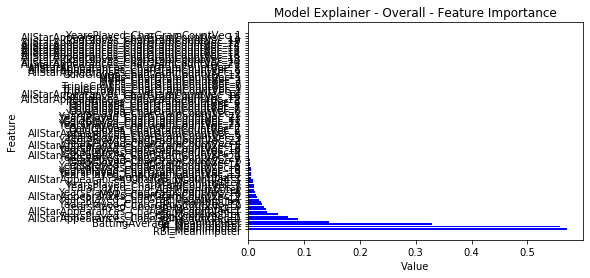

In [36]:
# Plot for Overall Feature Importance
x = overall_imp
summaryValues = overall_summary

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, summaryValues, color='blue')
plt.ylabel("Feature")
plt.xlabel("Value")
plt.title("Model Explainer - Overall - Feature Importance")

plt.yticks(x_pos, x)
plt.show()